<a href="https://colab.research.google.com/github/anorlo/Pytorch/blob/master/contextdesc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !pip uninstall imgaug
# !pip install imgaug==0.2.6

In [0]:
# !pip install moviepy
# !pip install imutils
# import cv2
# import time
# import matplotlib.pyplot as plt
# import moviepy
# from moviepy.editor import VideoFileClip
# import glob
# %matplotlib inline
# import numpy as np
# import imutils
# !python -V
# !pip3 install opencv-contrib-python
# !pip uninstall opencv-python
# !pip uninstall opencv-contrib-python
# !pip install opencv-contrib-python==3.4.2.16
# !pip install opencv-python==3.4.2.16

In [5]:
import cv2
cv2.__version__

'3.4.2'

In [6]:
import os
path = "/content/drive/My Drive/contextdesc"

os.chdir(path)
os.listdir(path)

['contextdesc']

In [0]:
# !git clone https://github.com/lzx551402/contextdesc.git

In [0]:
# ! pwd
# % cd pretrained


In [0]:
# # ! wget https://research.altizure.com/data/contextdesc_models/contextdesc_pp.tar
# ! wget https://research.altizure.com/data/contextdesc_models/retrieval_model.tar

In [0]:
# ! tar -xvf retrieval_model.tar

In [10]:
% cd contextdesc
! pwd


/content/drive/My Drive/contextdesc/contextdesc
/content/drive/My Drive/contextdesc/contextdesc


In [0]:
# ! python image_matching.py --h

4 [<KeyPoint 0x7f3793f74f00>, <KeyPoint 0x7f3793f74ed0>, <KeyPoint 0x7f3793f21330>, <KeyPoint 0x7f3793f21360>, <KeyPoint 0x7f3793f21030>, <KeyPoint 0x7f3793f21390>, <KeyPoint 0x7f3793f213c0>, <KeyPoint 0x7f3793f213f0>, <KeyPoint 0x7f3793f21420>, <KeyPoint 0x7f3793f21450>, <KeyPoint 0x7f3793f21480>, <KeyPoint 0x7f3793f214b0>, <KeyPoint 0x7f3793f214e0>, <KeyPoint 0x7f3793f21510>, <KeyPoint 0x7f3793f21540>, <KeyPoint 0x7f3793f21570>, <KeyPoint 0x7f3793f215a0>, <KeyPoint 0x7f3793f215d0>, <KeyPoint 0x7f3793f21600>, <KeyPoint 0x7f3793f21630>, <KeyPoint 0x7f3793f21660>, <KeyPoint 0x7f3793f21690>, <KeyPoint 0x7f3793f216c0>, <KeyPoint 0x7f3793f216f0>, <KeyPoint 0x7f3793f21720>, <KeyPoint 0x7f3793f21750>, <KeyPoint 0x7f3793f21780>, <KeyPoint 0x7f3793f217b0>, <KeyPoint 0x7f3793f217e0>, <KeyPoint 0x7f3793f21810>, <KeyPoint 0x7f3793f21840>, <KeyPoint 0x7f3793f21870>, <KeyPoint 0x7f3793f218a0>, <KeyPoint 0x7f3793f218d0>, <KeyPoint 0x7f3793f21900>, <KeyPoint 0x7f3793f21930>, <KeyPoint 0x7f3793f21960>

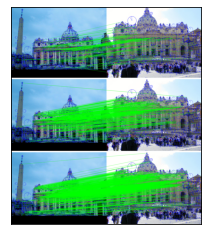

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [12]:
#!/usr/bin/env python3
"""
Copyright 2019, Zixin Luo, HKUST.
Image matching example.
"""
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils.opencvhelper import MatcherWrapper

from models import get_model


FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('loc_model', 'pretrained/contextdesc++',
                           """Path to the local feature and augmentation model.""")
tf.app.flags.DEFINE_string('reg_model', 'pretrained/retrieval_model',
                           """Path to the regional feature model.""")
tf.app.flags.DEFINE_string('img1_path', 'imgs/test_img1.jpg',
                           """Path to the first image.""")
tf.app.flags.DEFINE_string('img2_path', 'imgs/test_img2.jpg',
                           """Path to the second image.""")
tf.app.flags.DEFINE_integer('n_sample', 2048,
                            """Maximum number of keypoints. Sampled by octave.""")
# model options
tf.app.flags.DEFINE_string('model_type', 'pb',
                           """Pre-trained model type.""")
tf.app.flags.DEFINE_boolean('dense_desc', False,
                            """Whether to use dense descriptor model.""")
# matching options
tf.app.flags.DEFINE_boolean('ratio_test', False,
                            """Whether to apply ratio test in matching.""")
tf.app.flags.DEFINE_boolean('cross_check', False,
                            """Whether to apply cross check in matching.""")


def load_imgs(img_paths):
    rgb_list = []
    gray_list = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[..., np.newaxis]
        img = img[..., ::-1]
        rgb_list.append(img)
        gray_list.append(gray)
    return rgb_list, gray_list


def extract_regional_features(rgb_list, model_path):
    reg_feat_list = []
    model = get_model('reg_model')(model_path)
    for _, val in enumerate(rgb_list):
        reg_feat = model.run_test_data(val)
        reg_feat_list.append(reg_feat)
    model.close()
    return reg_feat_list


def extract_local_features(gray_list, model_path):
    cv_kpts_list = []
    loc_info_list = []
    loc_feat_list = []
    sift_feat_list = []
    model = get_model('loc_model')(model_path, **{'sift_desc': True,
                                                  'n_sample': FLAGS.n_sample,
                                                  'peak_thld': 0.04,
                                                  'dense_desc': FLAGS.dense_desc,
                                                  'upright': False})
    for _, val in enumerate(gray_list):
        # print(val)
        loc_feat, kpt_mb, normalized_xy, cv_kpts, sift_desc = model.run_test_data(val)
        # print(loc_feat)
        raw_kpts = [np.array((i.pt[0], i.pt[1], i.size, i.angle, i.response)) for i in cv_kpts]
        raw_kpts = np.stack(raw_kpts, axis=0)
        loc_info = np.concatenate((raw_kpts, normalized_xy, loc_feat, kpt_mb), axis=-1)
        cv_kpts_list.append(cv_kpts)
        loc_info_list.append(loc_info)
        sift_feat_list.append(sift_desc)
        loc_feat_list.append(loc_feat / np.linalg.norm(loc_feat, axis=-1, keepdims=True))
    model.close()
    return cv_kpts_list, loc_info_list, loc_feat_list, sift_feat_list


def extract_augmented_features(reg_feat_list, loc_info_list, model_path):
    aug_feat_list = []
    model = get_model('aug_model')(model_path, **{'quantz': False})
    assert len(reg_feat_list) == len(loc_info_list)
    for idx, _ in enumerate(reg_feat_list):
        aug_feat, _ = model.run_test_data([reg_feat_list[idx], loc_info_list[idx]])
        aug_feat_list.append(aug_feat)
    model.close()
    return aug_feat_list


def main(argv=None):  # pylint: disable=unused-argument
    """Program entrance."""
    if FLAGS.model_type == 'pb':
        reg_model_path = os.path.join(FLAGS.reg_model, 'reg.pb')
        loc_model_path = os.path.join(FLAGS.loc_model, 'loc.pb')
        aug_model_path = os.path.join(FLAGS.loc_model, 'aug.pb')
    elif FLAGS.model_type == 'ckpt':
        reg_model_path = os.path.join(FLAGS.reg_model, 'model.ckpt-550000')
        loc_model_path = os.path.join(FLAGS.loc_model, 'model.ckpt-400000')
        aug_model_path = os.path.join(FLAGS.loc_model, 'model.ckpt-400000')
    else:
        raise NotImplementedError

    img_paths = [FLAGS.img1_path, FLAGS.img2_path]
    # load testing images.
    rgb_list, gray_list = load_imgs(img_paths)
    # extract regional features.
    reg_feat_list = extract_regional_features(rgb_list, reg_model_path)
    # extract local features and keypoint matchability.
    cv_kpts_list, loc_info_list, loc_feat_list, sift_feat_list = extract_local_features(gray_list, loc_model_path)
    # extract augmented features.
    aug_feat_list = extract_augmented_features(reg_feat_list, loc_info_list, aug_model_path)
    # feature matching and draw matches.
    matcher = MatcherWrapper()
    sift_match, sift_mask = matcher.get_matches(
        sift_feat_list[0], sift_feat_list[1], cv_kpts_list[0], cv_kpts_list[1],
        ratio=0.8 if FLAGS.ratio_test else None, cross_check=FLAGS.cross_check,
        err_thld=3, ransac=True, info='SIFT feautre')

    base_match, base_mask = matcher.get_matches(
        loc_feat_list[0], loc_feat_list[1], cv_kpts_list[0], cv_kpts_list[1],
        ratio=0.89 if FLAGS.ratio_test else None, cross_check=FLAGS.cross_check,
        err_thld=3, ransac=True, info='Raw local feature')

    aug_match, aug_mask = matcher.get_matches(
        aug_feat_list[0], aug_feat_list[1], cv_kpts_list[0], cv_kpts_list[1],
        ratio=0.89 if FLAGS.ratio_test else None, cross_check=FLAGS.cross_check,
        err_thld=3, ransac=True, info='Augmented local feature')

    sift_disp = matcher.draw_matches(
        rgb_list[0], cv_kpts_list[0], rgb_list[1], cv_kpts_list[1], sift_match, sift_mask)
    base_disp = matcher.draw_matches(
        rgb_list[0], cv_kpts_list[0], rgb_list[1], cv_kpts_list[1], base_match, base_mask)
    aug_disp = matcher.draw_matches(
        rgb_list[0], cv_kpts_list[0], rgb_list[1], cv_kpts_list[1], aug_match, aug_mask)

    rows, cols = sift_disp.shape[0:2]
    white = (np.ones((int(rows / 50), cols, 3)) * 255).astype(np.uint8)
    disp = np.concatenate([sift_disp, white, base_disp, white, aug_disp], axis=0)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp)
    plt.show()


if __name__ == '__main__':
    tf.compat.v1.app.run()